## Author: Chia-Yun (Sandy) Chiang

# Introduction

In this project, we have two topics:
- Topic 1 - Who will leave? - attrition prediction using logistic regression
- Topic 2 - Who will transcat?  - transaction prediction using logistic regression

Since topic 1 and topic 2 both need to use the logistic regression model, I'll define some automation functions for reusing these code.

### Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.model_selection import KFold
import random
from numpy.random import randint
%matplotlib inline

In [2]:
plt.style.use('seaborn-white')
plt.style.use('seaborn-pastel')
plt.rcParams["figure.figsize"] = (24,8)

In [3]:
attrition_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRAXWHW6gEfYyarTw9o5hCvAnx5vPH4O1WFXVZT32iU7tFQP9KVdxH_XO6BKEGok9yuelVoeG76p4eM/pub?gid=1144642818&single=true&output=csv"
baseball_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQigI7-AKrL7SwQCp0zZjvvuaL12fpMxttsxSulXY4v2YjsvHWWP9MTo4fZqqCGXAFArICg0l38m9Re/pub?gid=1398581801&single=true&output=csv"
transact_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vT5jWOTHnxTJ0uqBrc6ucecNRMaEQB0cV4t-IK6pJ75OmbItpsEdZ0-xevlu2rc_1mGbZlmkCODKyB5/pub?gid=1913800437&single=true&output=csv"

# Topic1 - Who will leave? - attrition prediction using logistic regression

## Overview of dataset

In [4]:
leave_df = pd.read_csv(attrition_path)

In [5]:
leave_df.head(3)

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept,salary
0,0.82,0.97,3,244,5,0,0,0,SALES,MEDIUM
1,0.75,0.81,2,247,4,0,0,0,HR,SMALL
2,0.54,0.81,4,257,2,0,0,0,ADMIN,SMALL


In [6]:
leave_df.tail(3)

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept,salary
11246,0.67,0.77,5,167,2,0,0,0,ADMIN,MEDIUM
11247,0.98,0.67,4,209,6,0,0,0,MKT,SMALL
11248,0.75,0.69,3,242,3,0,0,0,SALES,LARGE


In [7]:
leave_df.shape

(11249, 10)

In [8]:
leave_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11249 entries, 0 to 11248
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_satisfaction    11249 non-null  float64
 1   last_performance_rating  11249 non-null  float64
 2   workload                 11249 non-null  int64  
 3   avg_montly_hours         11249 non-null  int64  
 4   tenure_years             11249 non-null  int64  
 5   ergo_issues              11249 non-null  int64  
 6   attrit                   11249 non-null  int64  
 7   promo_in_last_5_years    11249 non-null  int64  
 8   dept                     11249 non-null  object 
 9   salary                   11249 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 879.0+ KB


In [9]:
leave_df.isnull().sum()

employee_satisfaction      0
last_performance_rating    0
workload                   0
avg_montly_hours           0
tenure_years               0
ergo_issues                0
attrit                     0
promo_in_last_5_years      0
dept                       0
salary                     0
dtype: int64

In [10]:
leave_df.describe()

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years
count,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000
mean,0.612957,0.716225,3.799716,201.176727,3.499600,0.144991,0.239577,0.021869
std,0.248235,0.171378,1.232190,50.058105,1.469892,0.352107,0.426844,0.146261
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,201.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [11]:
obj_list = list(leave_df.select_dtypes(include = ["object"]).columns)
leave_df[obj_list].describe()

,dept,salary
count,11249,11249
unique,10,3
top,SALES,SMALL
freq,3098,5445


In [12]:
# Show the percentage of our target column > check if it is inbalance
leave_df["attrit"].value_counts()/leave_df["attrit"].value_counts().sum()

0    0.760423
1    0.239577
Name: attrit, dtype: float64

## Define exploration function (plot and table)

In [13]:
# Define function which generate coutplot of all the dataset
def generate_countplot(df, target_column, color, palette):
  for i in df.columns:
    plt.figure()
    sns.countplot(data=df, x=i, hue = target_column, color=color, palette=palette)

In [14]:
# Define function which generate percentage table
def generate_perc_table(group1, group2, df):
  count = df.groupby([group1, group2]).agg({group2:"count"})
  perc = count.groupby(level=0).apply(lambda x:round(100*x/x.sum(),2))
  print(perc)

In [15]:
# Define function which generate percenrage table for all the dataset
def generate_all_perc_table(df, target_column):
  for i in df.columns:
    generate_perc_table(i, target_column, df)


In [16]:
# Define function which generate distplot
# color ref: https://python-graph-gallery.com/100-calling-a-color-with-seaborn/
def generate_distplot(df, target_column, compare_column, subset0_name, subset1_name):
  subset0 = df[compare_column].loc[df[target_column] == 0]
  subset1 = df[compare_column].loc[df[target_column] == 1]
  sns.set_style('whitegrid')
  ax = sns.distplot(subset0, hist=True, kde_kws=dict(linewidth=4), color = "skyblue" )
  ax = sns.distplot(subset1, hist=True, kde_kws=dict(linewidth=4), color = "sandybrown")
  plt.legend([subset0_name, subset1_name],fontsize=20)

## Explore the dataset

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


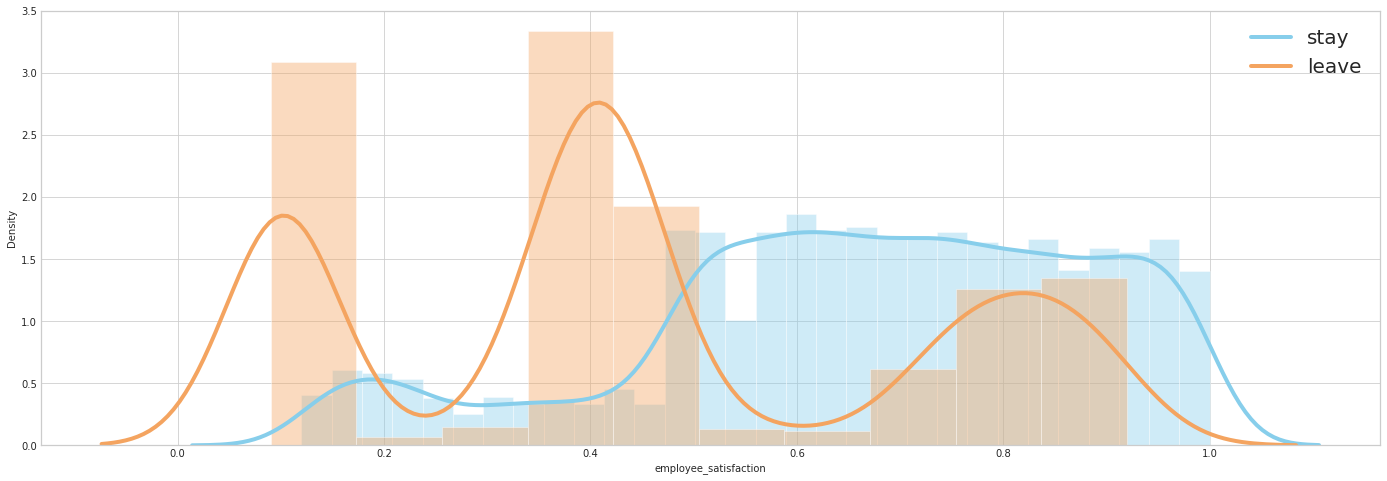

In [17]:
generate_distplot(leave_df, "attrit", "employee_satisfaction", "stay", "leave")

**Summary**
- Most of the employees who stay in the company have satisfaction score between 0.5~1.
- Empolyees who have satisfaction score:     
(1) below 0.2   
(2) between 0.35 to 0.5    
(3) between 0.7 to 0.9     
have more tendency to leave the company.
- Higher satisfaction might be a factor that remains the current employees, vice versa.    
- People who decide to leave the company might also have high satisfaction score, but leave the company because of other drivers (e.g. other great opportunties, higher salaries, geographical considerations...)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


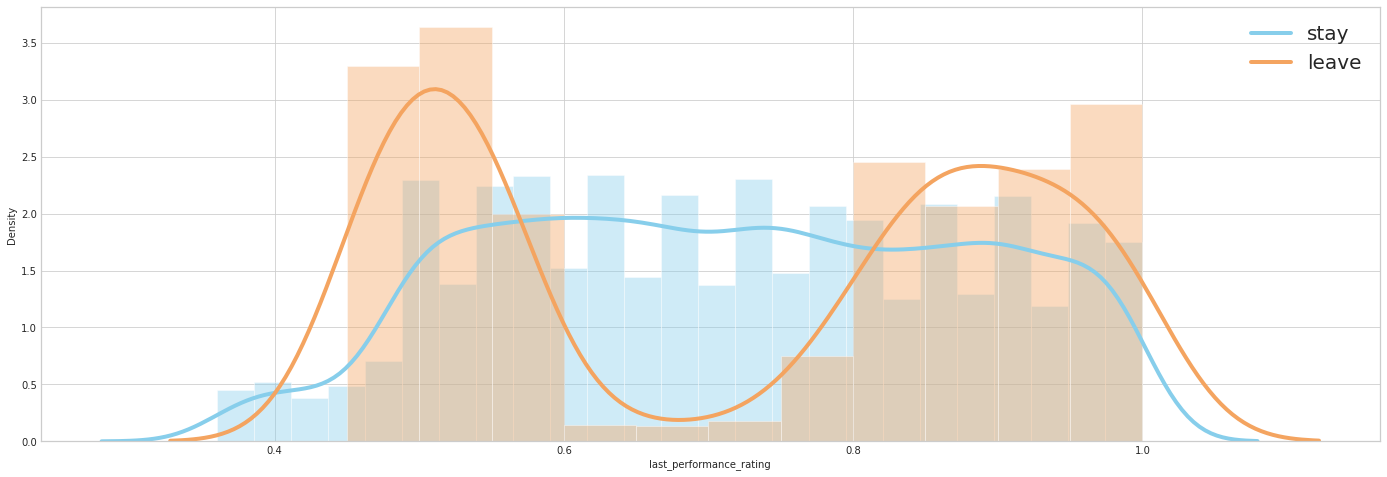

In [18]:
generate_distplot(leave_df, "attrit", "last_performance_rating", "stay", "leave")

**Summary**      
- Based on the density plot, we found that people who have lower last performance rating (less than 0.6) and people who have high last perofrmance rating (0.8~1) are more likely to leave the company.
- Above two groups indicate that "last performance rating" might be a driver that caused people to leave. However, we do not know the exact reasoning.   
- Possible reasons of leaving:    
  - Maybe people who have low performance rate feel too stressful of their current job.
  - Maybe people who have low performance rate feel their work did not earn the credit they deserved.
  - Maybe people who have high performance rate have better opportunities outside of the company.
  - Maybe people who have high performance rate already decided to leave after having the promotion.
  - Might be other reasons, but we can't tell through the existing data.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


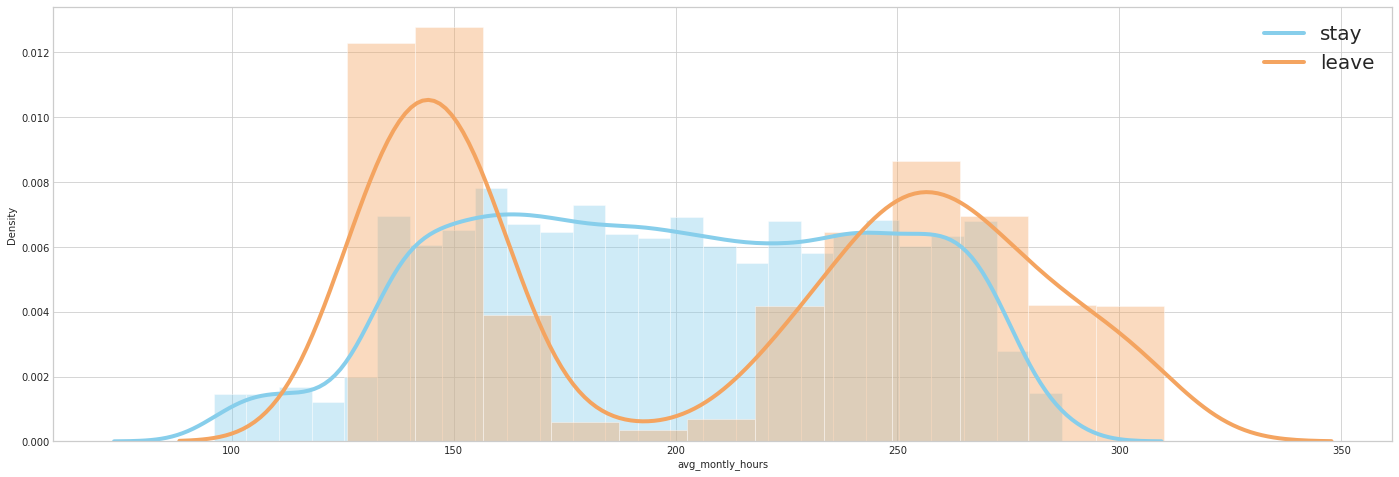

In [19]:
generate_distplot(leave_df, "attrit", "avg_montly_hours", "stay", "leave")

**Summary**
- Based on the density plot, we found that people who have lower average monthly hours (less than 180 hours) and people who have high average monthly hours (225~300 hours) are more likely to leave the company.
- Above two groups indicate that "average monthly hours" might be a driver that caused people to leave. However, we do not know the exact reasoning.
- These plot is similar as above "last performance rating plot". We might guess people who have higher average monthly hours might be the group which has higher performance rating, vice versa.

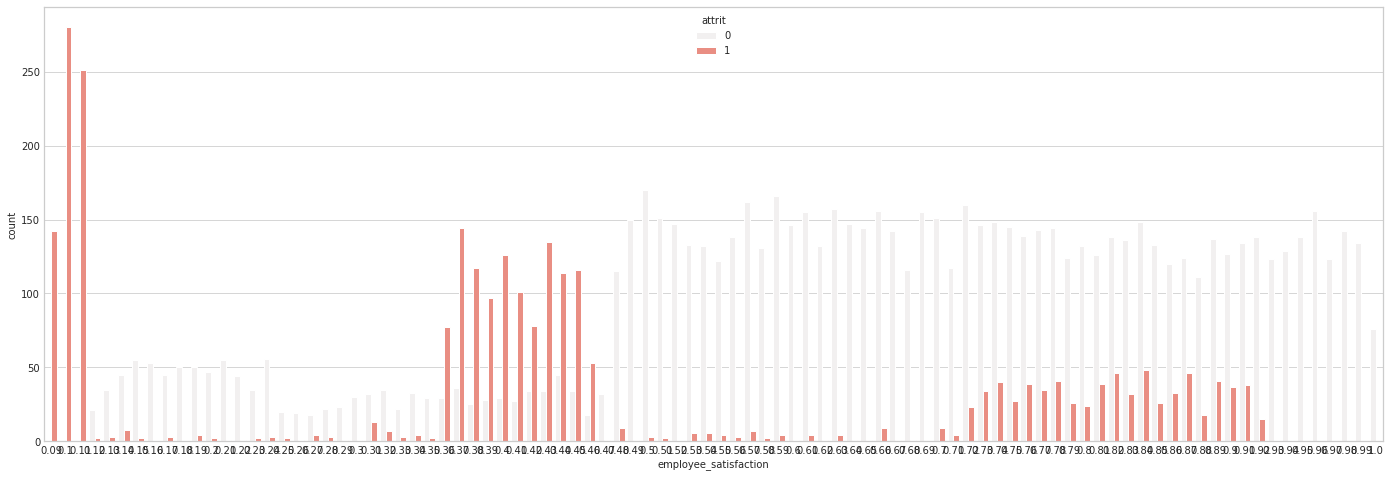

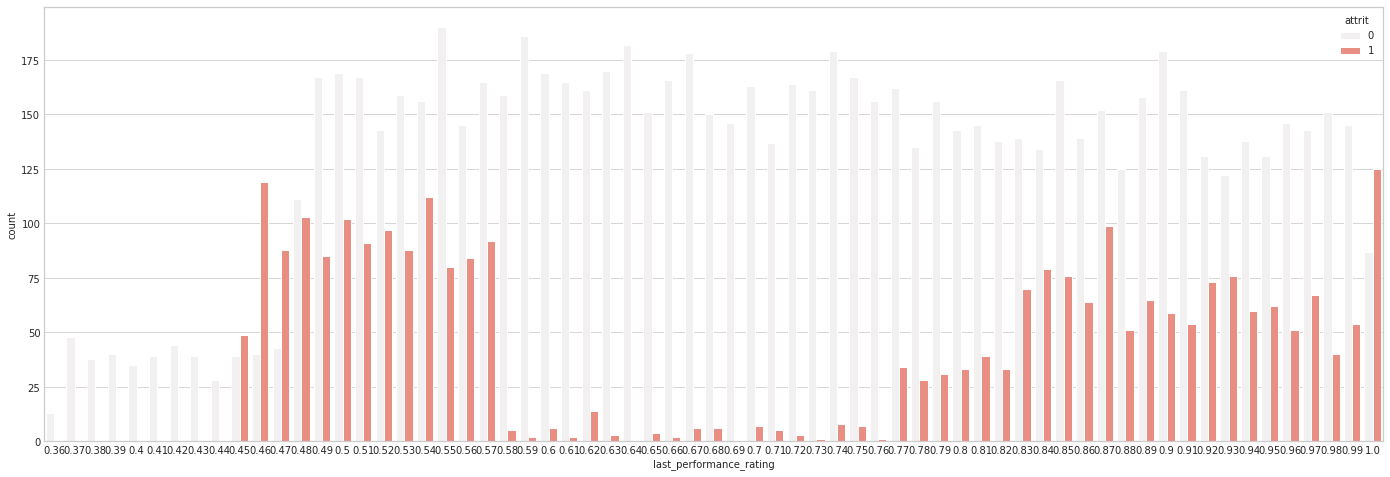

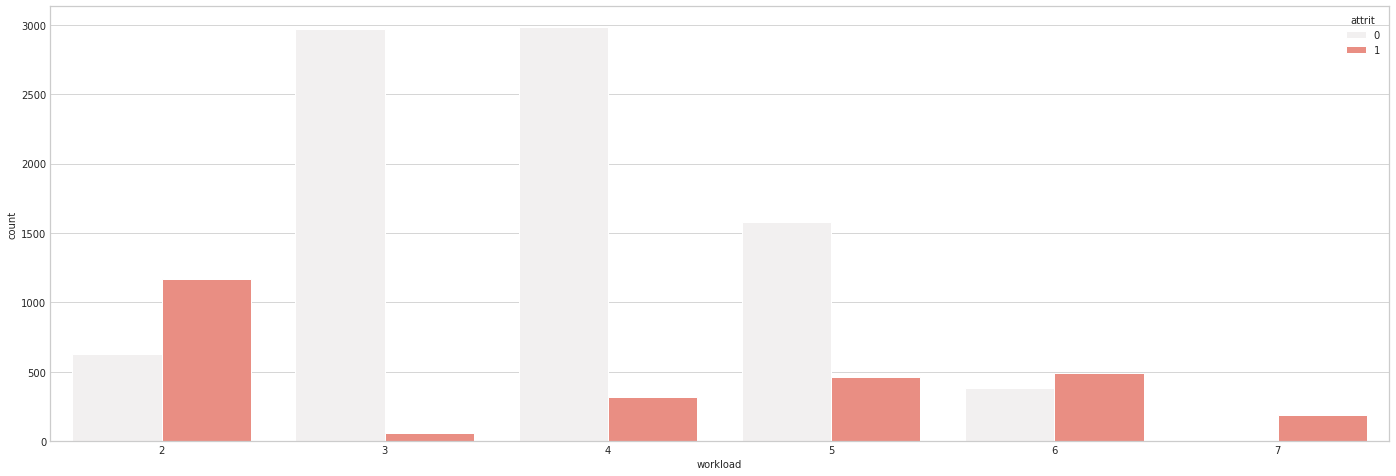

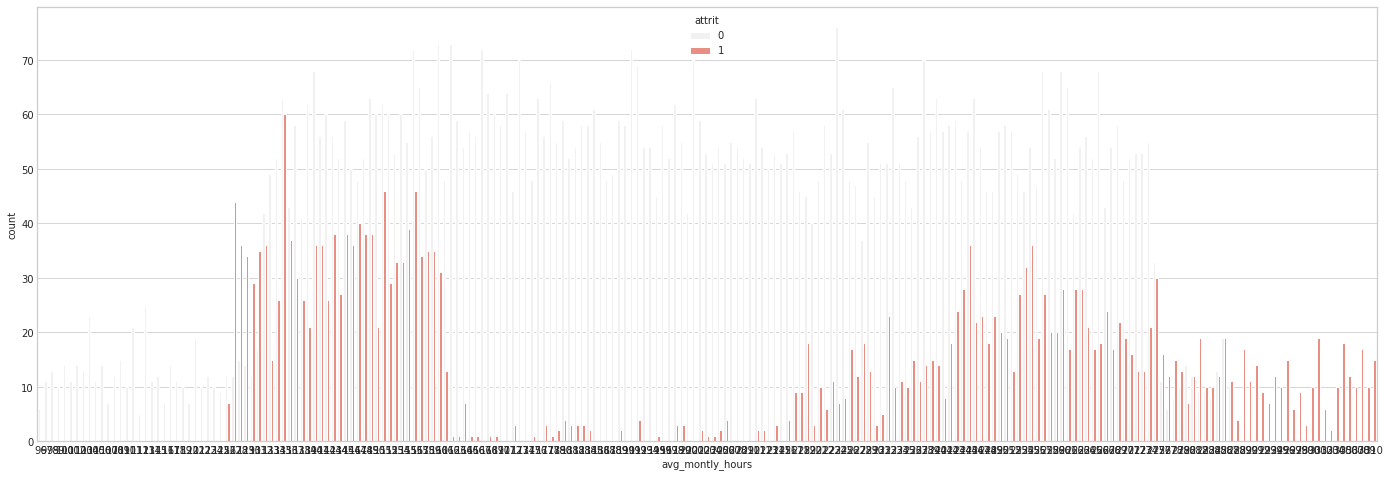

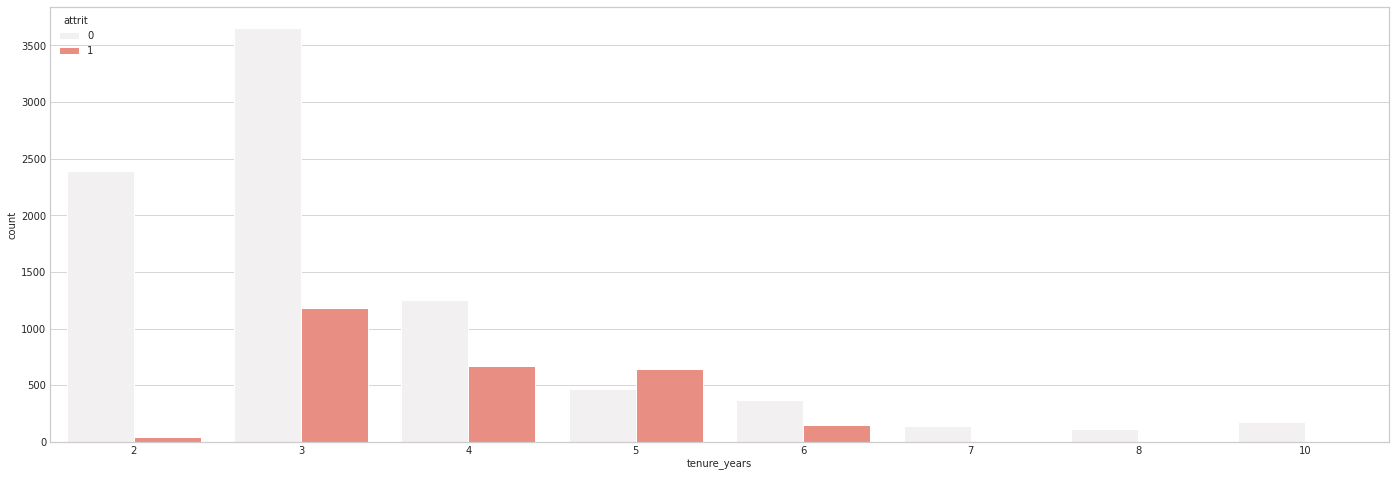

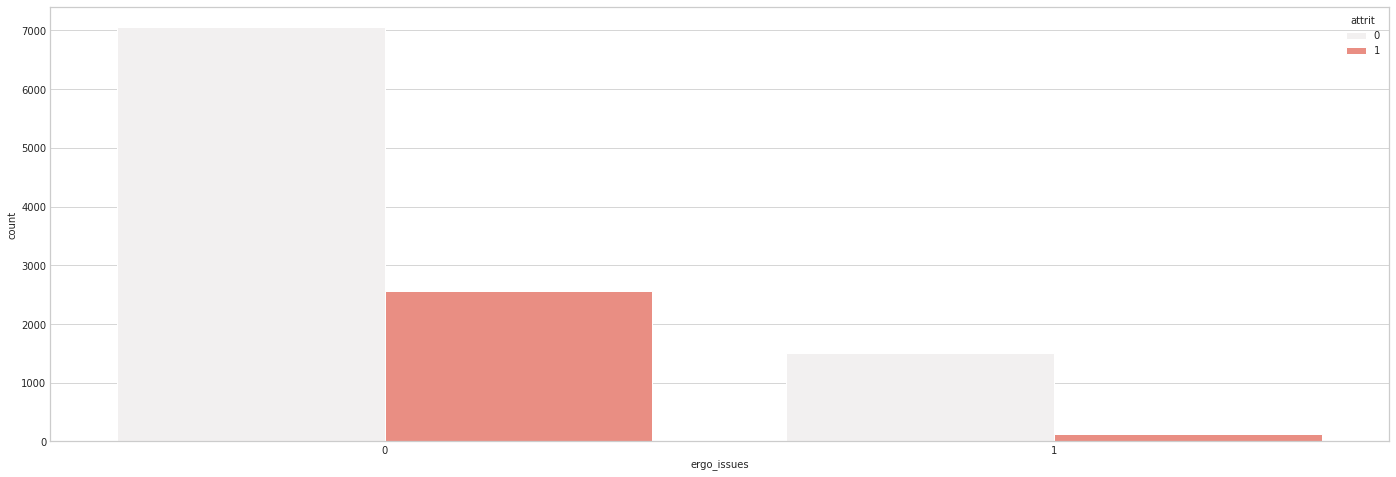

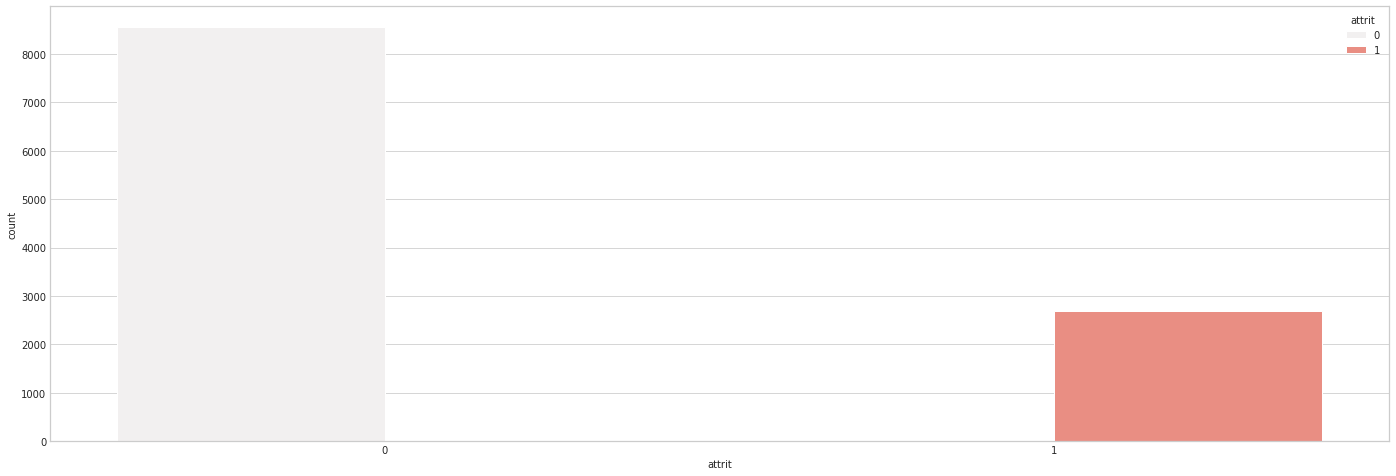

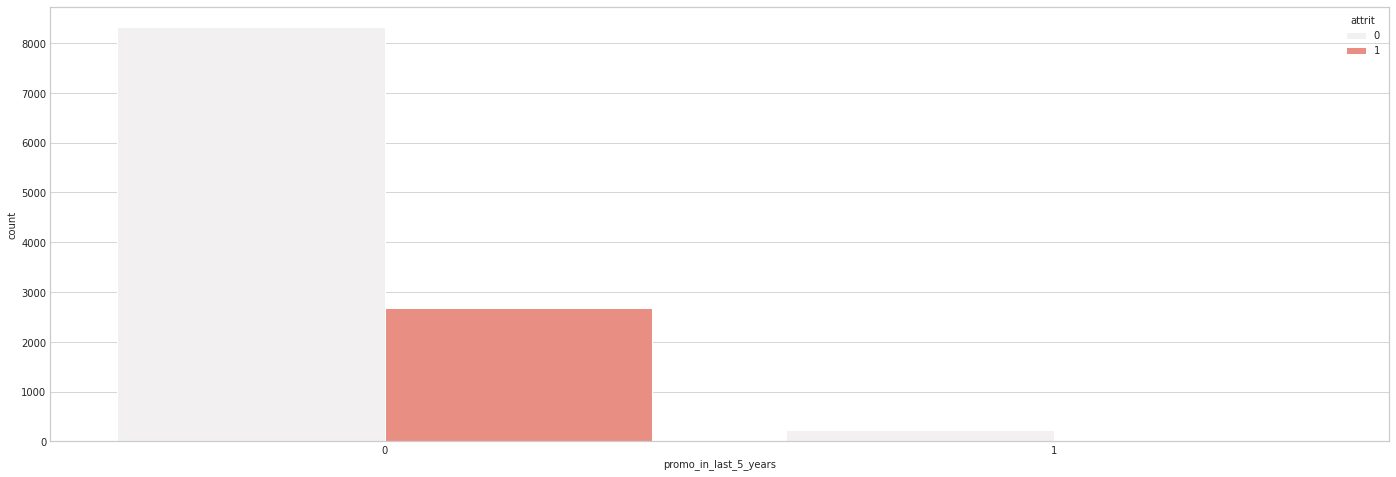

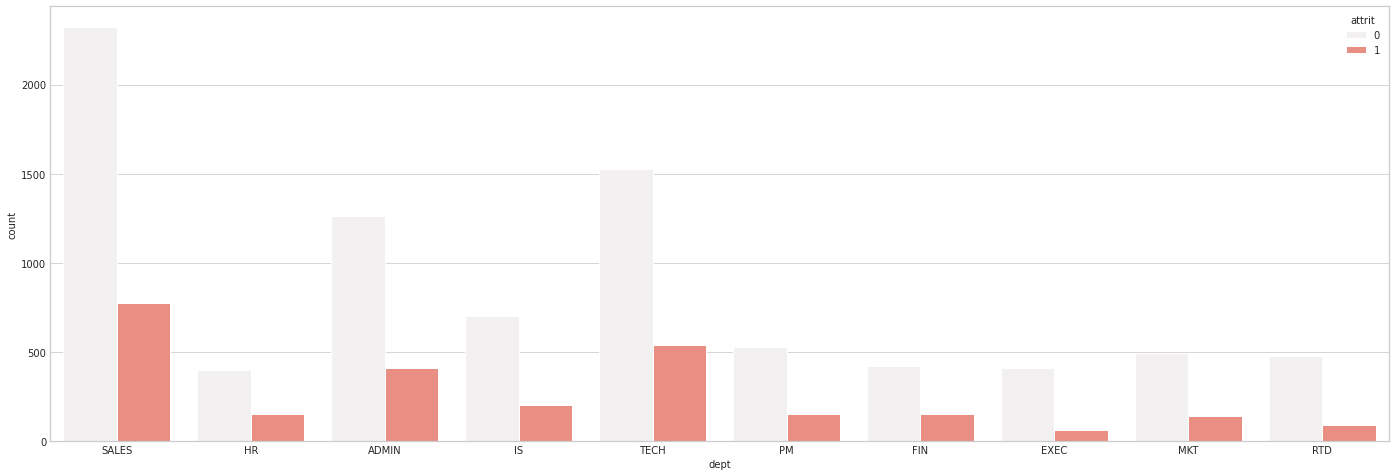

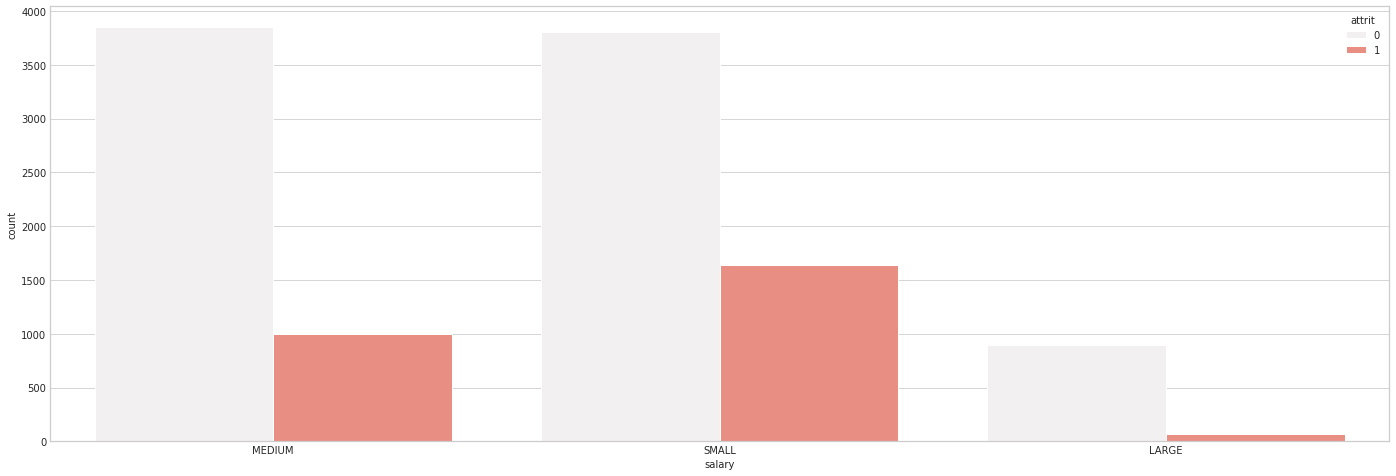

In [20]:
generate_countplot(leave_df, "attrit", color = "salmon", palette = None)

In [21]:
generate_all_perc_table(leave_df, "attrit")

                              attrit
employee_satisfaction attrit        
0.09                  1        100.0
0.10                  1        100.0
0.11                  1        100.0
0.12                  0         91.3
                      1          8.7
...                              ...
0.96                  0        100.0
0.97                  0        100.0
0.98                  0        100.0
0.99                  0        100.0
1.00                  0        100.0

[169 rows x 1 columns]
                                attrit
last_performance_rating attrit        
0.36                    0       100.00
0.37                    0       100.00
0.38                    0       100.00
0.39                    0       100.00
0.40                    0       100.00
...                                ...
0.98                    1        20.94
0.99                    0        72.86
                        1        27.14
1.00                    0        41.04
                        1  

**Summary**     
According to our plot and percentage table, we found that **(1) salary (2) promotion in last 5 years** are two relevant atrributes to attrition.

The percenrage for people who leaves:
- Salary - Small salary: 30.5% ; Medium salary 20.54%; Large salary: 6.67%
- Promotion - have promotion in last 5 years: 4.47%; no promotion in last years: 24.39%
- People have small salary are more likely to leave.
- People have no promotion in last years are more likely to leave.


- Other facotrs, such as workload, ergo issues, tenure years do not show the 
obvious pattern that might cause people to leave.
- If we look at the department attribute, we could find that people in EXEC, RTD department have the relatively low percentage to leave (13.47% and 15.75% respectively); while other departments have around 22~27% of people leaving the company.

## Define function for running the logistic regression model

In [22]:
# Define function which find the best K (number of attributes) and the exact attributes as our training data
def run_logistic_regression_with_different_k(df, target_column):
    # Assign feature selection data 
    fs_y = df[target_column]
    fs_X = df.loc[:, df.columns != target_column]
    # Iterate with the number of X column 
    for i in range(fs_X.shape[1]):
      lr_model = LogisticRegression(max_iter=1000)
      rfe = RFE(lr_model, i+1)
      fit = rfe.fit(fs_X, fs_y)
      X_column = []
      # Iterate with fit.ranking to get the best attribute
      for j in range(len(fit.ranking_)):
        if fit.ranking_[j] == 1: # fit.ranking_ number equals to 1 indicates this attribute we want to select
          X_column.append(fs_X.columns[j])

      # Assign training and target data
      X = fs_X[X_column].values
      y = df[target_column]
      # Train and fit model
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
      lr_model.fit(X_train, y_train)
      y_predict = lr_model.predict(X_test)

      # Model evaluation metrics
      accuracy = accuracy_score(y_test, y_predict)
      mse = mean_squared_error(y_test, y_predict)
      cr_result = classification_report(y_test, y_predict)
      cv_scores = cross_val_score(lr_model, X, y, scoring='accuracy', cv=10)

      print("Select {} attributes as training data".format(i+1) )
      print("The training attributes includes:", X_column) 
      print("Model performance as below:")
      print("(1) Classification_report:")
      print(cr_result)
      print("(2) Accuracy:", accuracy) 
      print("(3) MSE:", mse)
      print("(4) Cross validation scores", cv_scores)
      print("(5) Cross validation mean scores", cv_scores.mean())
      print("----------------------------------------------------------")

In [23]:
leave_df.head(3)

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept,salary
0,0.82,0.97,3,244,5,0,0,0,SALES,MEDIUM
1,0.75,0.81,2,247,4,0,0,0,HR,SMALL
2,0.54,0.81,4,257,2,0,0,0,ADMIN,SMALL


In [24]:
# create dummy for categorical column
leave_df = pd.get_dummies(data=leave_df, columns=["dept","salary"])

In [25]:
leave_df.head(3)

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept_ADMIN,dept_EXEC,dept_FIN,dept_HR,dept_IS,dept_MKT,dept_PM,dept_RTD,dept_SALES,dept_TECH,salary_LARGE,salary_MEDIUM,salary_SMALL
0,0.82,0.97,3,244,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0.75,0.81,2,247,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0.54,0.81,4,257,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [26]:
run_logistic_regression_with_different_k(leave_df, "attrit")

Select 1 attributes as training data
The training attributes includes: ['employee_satisfaction']
Model performance as below:
(1) Classification_report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      2148
           1       0.56      0.27      0.37       665

    accuracy                           0.78      2813
   macro avg       0.68      0.60      0.62      2813
weighted avg       0.75      0.78      0.75      2813

(2) Accuracy: 0.7778172769285461
(3) MSE: 0.22218272307145395
(4) Cross validation scores [0.77422222 0.77333333 0.77422222 0.77155556 0.76266667 0.77244444
 0.76088889 0.76888889 0.76266667 0.76779359]
(5) Cross validation mean scores 0.768868248319494
----------------------------------------------------------
Select 2 attributes as training data
The training attributes includes: ['employee_satisfaction', 'promo_in_last_5_years']
Model performance as below:
(1) Classification_report:
              precision    reca

**Summary**
- The overall performance (Accuracy, MSE, Cross validation mean scores) of above 20 models do not have much difference.
- If we look at the f1-score of classification 1 (indicates attrition), the models with training attributes less than 11 has lower f1-score (~0.35). As a result, I would like to select a model which used more than 11 training attributes (Best K > 11).
- I'll choose the model which used 14 training attributes (K = 14) as my model since it seems has a great score among all the other models.

**Reference**
- [ConvergenceWarning: lbfgs failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT](https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter)
- [Feature Selection For Machine Learning in Python](https://machinelearningmastery.com/feature-selection-machine-learning-python/)

### Logistic regression model for attrition prediction

In [27]:
X = leave_df[['employee_satisfaction', 'last_performance_rating', 'workload', 'tenure_years', \
     'ergo_issues', 'promo_in_last_5_years', 'dept_EXEC', 'dept_HR', 'dept_IS', 'dept_RTD',\
     'dept_TECH', 'salary_LARGE', 'salary_MEDIUM', 'salary_SMALL']].values
y = leave_df["attrit"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
lr_attrit_model = LogisticRegression(max_iter=1000)
lr_attrit_model.fit(X_train, y_train)
y_predict = lr_attrit_model.predict(X_test)

# Model evaluation metrics
accuracy = accuracy_score(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
cr_result = classification_report(y_test, y_predict)
cv_scores = cross_val_score(lr_attrit_model, X, y, scoring='accuracy', cv=10)

print("Model performance as below:")
print("(1) Classification_report:")
print(cr_result)
print("(2) Accuracy:", accuracy) 
print("(3) MSE:", mse)
print("(4) Cross validation scores", cv_scores)
print("(5) Cross validation mean scores", cv_scores.mean())


Model performance as below:
(1) Classification_report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      2148
           1       0.62      0.38      0.47       665

    accuracy                           0.80      2813
   macro avg       0.72      0.65      0.67      2813
weighted avg       0.78      0.80      0.78      2813

(2) Accuracy: 0.7980803412726626
(3) MSE: 0.20191965872733736
(4) Cross validation scores [0.80088889 0.79022222 0.79822222 0.79644444 0.79111111 0.78666667
 0.79466667 0.80355556 0.78488889 0.77669039]
(5) Cross validation mean scores 0.7923357058125742


**Summary of attrition model using logistic regression**
- The overall performance of this model is great. We have overall accuracy = 0.8, MSE = 0.2, cross validation mean scores = 0.79, which indicates these model perform well in overall accuracy.
- However, if we look at classification = 1, we could see that, for predicting people who really attrit, we have precision = 0.62 and recall = 0.38. The recall is very low, which indicates that we might miss lots of real attrition people while predicting.
- Since our original dataset is inbalance (more data with attrition = 0; less data with attrition = 1), this might be the reason we get this model with low f1-score for attrition = 1. 
- In my opinion, this model is less useful since our target is to predict "people who will leave?". In other words, if there are total 100 people will definitely leave the company, our model could only identify 38 of them - which miss the majority of people (62 people). 

**Reference**
- [Precision vs. Recall – An Intuitive Guide for Every Machine Learning Person](https://www.analyticsvidhya.com/blog/2020/09/precision-recall-machine-learning/)

## Generate some sample data for predicting using our model

In [28]:
leave_df.head(1)

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept_ADMIN,dept_EXEC,dept_FIN,dept_HR,dept_IS,dept_MKT,dept_PM,dept_RTD,dept_SALES,dept_TECH,salary_LARGE,salary_MEDIUM,salary_SMALL
0,0.82,0.97,3,244,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [29]:
leave_df.avg_montly_hours.describe()

count    11249.000000
mean       201.176727
std         50.058105
min         96.000000
25%        156.000000
50%        201.000000
75%        245.000000
max        310.000000
Name: avg_montly_hours, dtype: float64

In [30]:
leave_df.workload.value_counts()

4    3301
3    3031
5    2045
2    1801
6     878
7     193
Name: workload, dtype: int64

In [31]:
leave_df.tenure_years.value_counts()

3     4841
2     2429
4     1923
5     1109
6      520
10     175
7      137
8      115
Name: tenure_years, dtype: int64

In [32]:
leave_df.ergo_issues.value_counts()

0    9618
1    1631
Name: ergo_issues, dtype: int64

In [33]:
x = [0 for i in range(10)]
x = x + [0 for i in range(5)]

In [34]:
# Generate random sample
random_input = pd.DataFrame(columns = leave_df.columns)
random.seed(30)
for i in range(5):
  x = [random.random() for i in range(2)]
  x.append(random.randint(2,7))
  x.append(random.randint(90, 400))
  x.append(random.randint(2, 10))
  x.append(random.randint(0, 1))
  x.append(0)
  x.append(random.randint(0, 1)) 
  x = x + [0 for i in range(13)]
  # select one department
  pick_1 = random.randint(8, 17)
  x[pick_1] = 1
  # select one salary level
  pick_2 = random.randint(18,20)
  x[pick_2] = 1
  random_input.loc[i] = x

**Reference**
- [How to Generate Random Numbers in Python](https://machinelearningmastery.com/how-to-generate-random-numbers-in-python/)
- [Create pandas Dataframe by appending one row at a time](https://stackoverflow.com/questions/10715965/create-pandas-dataframe-by-appending-one-row-at-a-time)

In [35]:
random_input

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept_ADMIN,dept_EXEC,dept_FIN,dept_HR,dept_IS,dept_MKT,dept_PM,dept_RTD,dept_SALES,dept_TECH,salary_LARGE,salary_MEDIUM,salary_SMALL
0,0.539082,0.289196,2.0,197.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.134071,0.081317,2.0,357.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.530824,0.401779,7.0,268.0,10.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.805294,0.671970,5.0,379.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.933746,0.129345,4.0,249.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
# Predict our sample data
sample_remaing_list = ['employee_satisfaction', 'last_performance_rating', 'workload', 'tenure_years', \
     'ergo_issues', 'promo_in_last_5_years', 'dept_EXEC', 'dept_HR', 'dept_IS', 'dept_RTD',\
     'dept_TECH', 'salary_LARGE', 'salary_MEDIUM', 'salary_SMALL']
sample_X = random_input[random_input.columns.intersection(sample_remaing_list)]
sample_predict = lr_attrit_model.predict(sample_X)


In [37]:
# Join the prediction into table
random_input.join(pd.DataFrame(sample_predict, columns= {"predict_attrition"}))

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept_ADMIN,dept_EXEC,dept_FIN,dept_HR,dept_IS,dept_MKT,dept_PM,dept_RTD,dept_SALES,dept_TECH,salary_LARGE,salary_MEDIUM,salary_SMALL,predict_attrition
0,0.539082,0.289196,2.0,197.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,0.134071,0.081317,2.0,357.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,0.530824,0.401779,7.0,268.0,10.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,0.805294,0.671970,5.0,379.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
4,0.933746,0.129345,4.0,249.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


**Summary**    
I randomly generated 5 sample data as the table above. According to our prediction model, we could see that the second record will be the person who might leave the company given by our model output. It seems reasonable since this record have low satisfaction score, low performance rating and small salary. Based on our previous exploratory data analysis, this person might be the one who very likely to leave the company.

# Topic 2 - Who will transact? - transaction prediction using logistic regression

In [38]:
transact_df= pd.read_csv(transact_path)

In [39]:
transact_df.head(3)

,row,transaction,salary_usd,is_male,is_married,is_college,is_professional,is_senior,is_employed,is_single_income,children_present,is_renter,lives_in_house,is_english_primary_language,previously_disney_customer,previous_streaming_service_customer
0,653,0,25000,1,0,0,0,0,0,1,0,1,0,1,0,0
1,546,0,7000,0,0,0,0,0,0,1,1,1,1,1,0,0
2,463,0,25000,1,0,0,1,0,0,1,1,1,0,1,1,0


In [40]:
transact_df.tail(3)

,row,transaction,salary_usd,is_male,is_married,is_college,is_professional,is_senior,is_employed,is_single_income,children_present,is_renter,lives_in_house,is_english_primary_language,previously_disney_customer,previous_streaming_service_customer
502,148,0,10000,0,0,0,0,0,1,1,1,1,0,1,0,0
503,47,0,55000,0,1,0,0,0,0,0,0,0,1,1,0,0
504,590,0,53000,0,0,0,1,0,0,1,0,1,0,1,0,0


In [41]:
transact_df.shape

(505, 16)

In [42]:
transact_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   row                                  505 non-null    int64
 1   transaction                          505 non-null    int64
 2   salary_usd                           505 non-null    int64
 3   is_male                              505 non-null    int64
 4   is_married                           505 non-null    int64
 5   is_college                           505 non-null    int64
 6   is_professional                      505 non-null    int64
 7   is_senior                            505 non-null    int64
 8   is_employed                          505 non-null    int64
 9   is_single_income                     505 non-null    int64
 10  children_present                     505 non-null    int64
 11  is_renter                            505 non-null    int64

In [43]:
transact_df.isnull().sum()

row                                    0
transaction                            0
salary_usd                             0
is_male                                0
is_married                             0
is_college                             0
is_professional                        0
is_senior                              0
is_employed                            0
is_single_income                       0
children_present                       0
is_renter                              0
lives_in_house                         0
is_english_primary_language            0
previously_disney_customer             0
previous_streaming_service_customer    0
dtype: int64

In [44]:
transact_df.describe().round()

,row,transaction,salary_usd,is_male,is_married,is_college,is_professional,is_senior,is_employed,is_single_income,children_present,is_renter,lives_in_house,is_english_primary_language,previously_disney_customer,previous_streaming_service_customer
count,505.0,505.0,505.0,505.0,505.0,505.0,505.0,505.0,505.0,505.0,505.0,505.0,505.0,505.0,505.0,505.0
mean,337.0,0.0,58224.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
std,196.0,0.0,39098.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,162.0,0.0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
50%,338.0,0.0,55000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
75%,506.0,0.0,86000.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
max,672.0,1.0,124000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [45]:
# Drop useless column
transact_df.drop(columns="row", inplace=True)

In [46]:
# Show the percentage of our target column > check if it is inbalance
transact_df["transaction"].value_counts()/transact_df["transaction"].value_counts().sum()

0    0.813861
1    0.186139
Name: transaction, dtype: float64

- Data is highly inbalanced

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


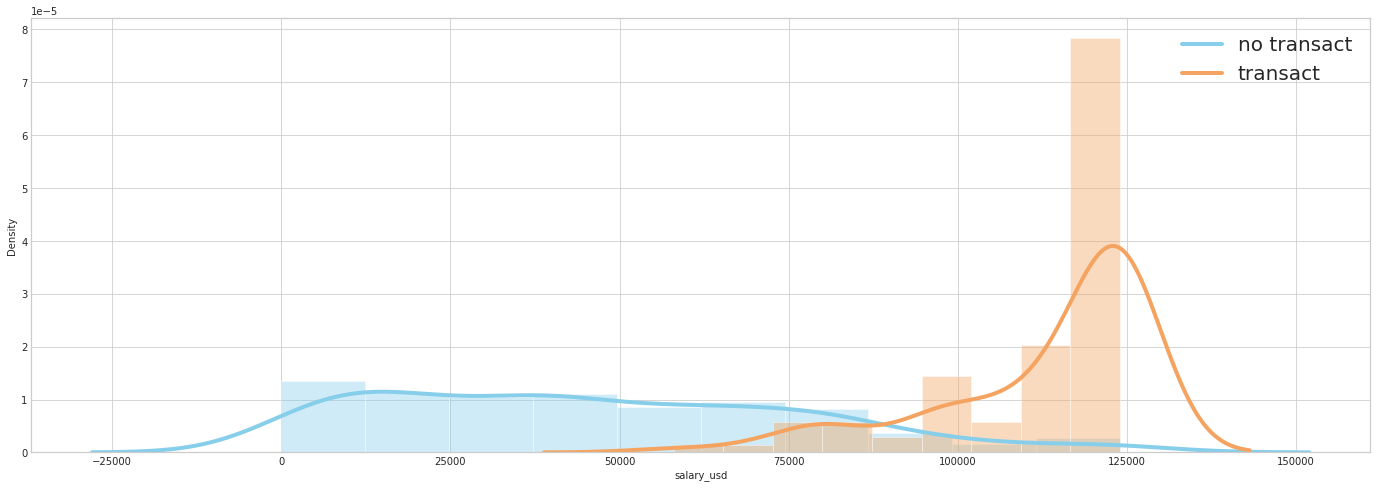

In [47]:
generate_distplot(transact_df, "transaction", "salary_usd", "no transact", "transact")

**Summary**
- People who have higher salary are more likely to transact than people who have lower salary.

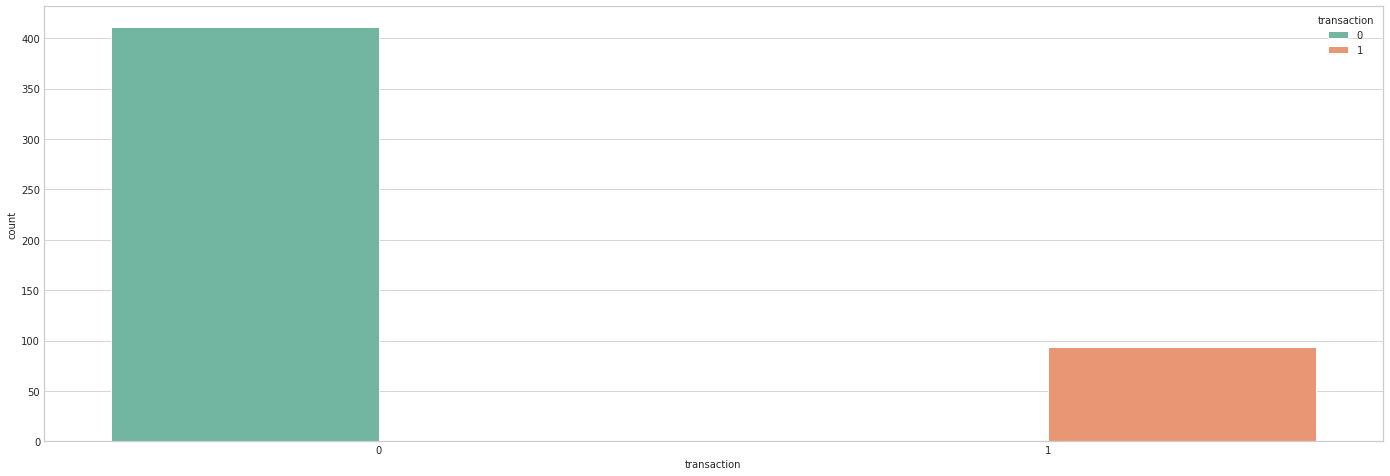

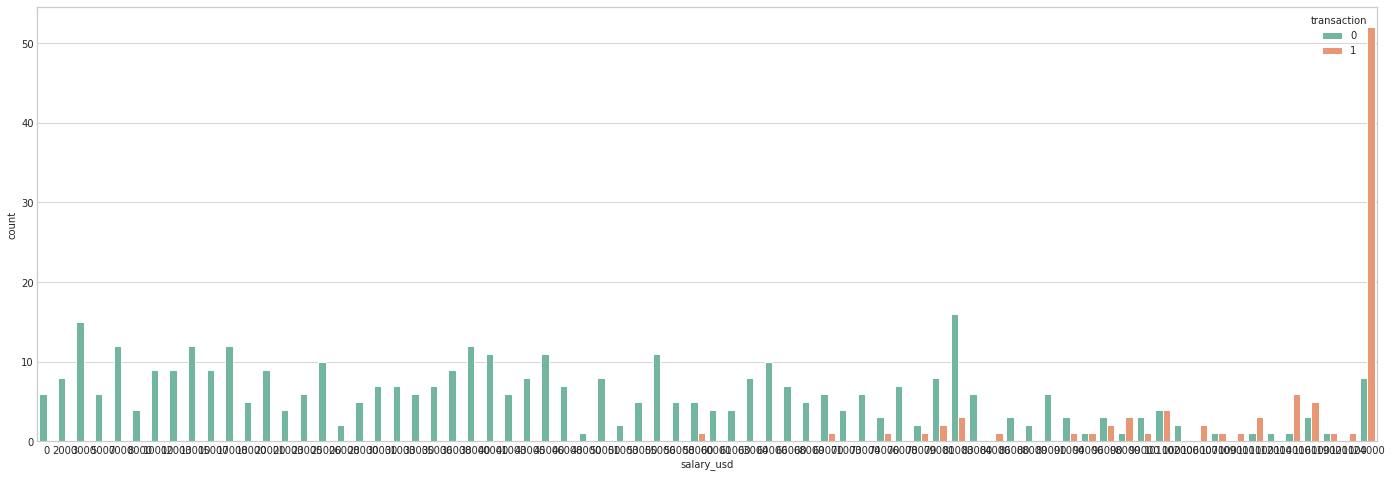

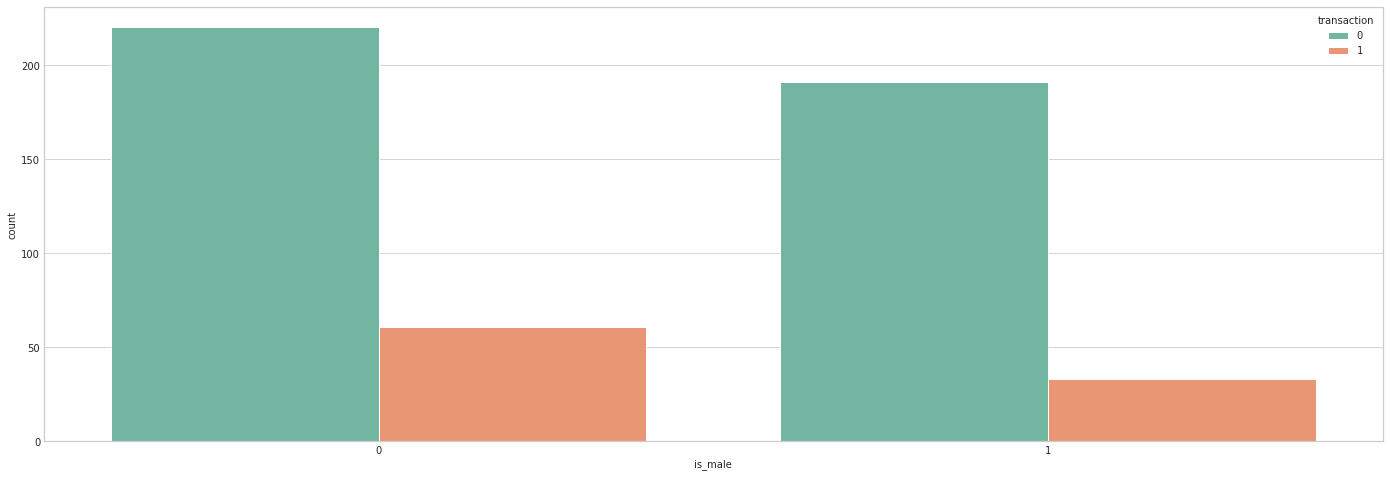

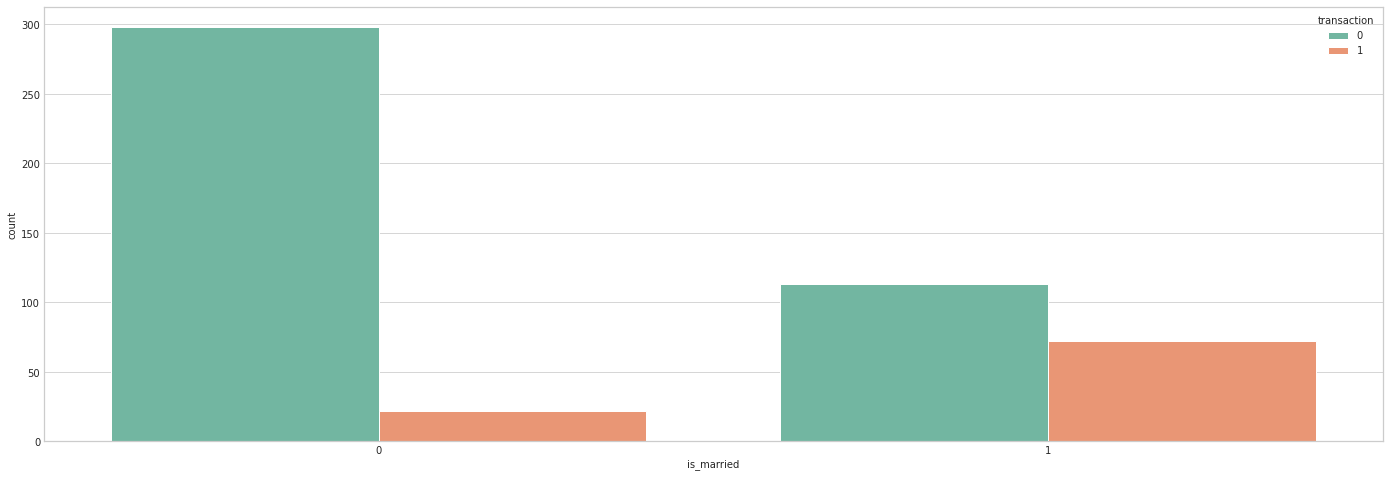

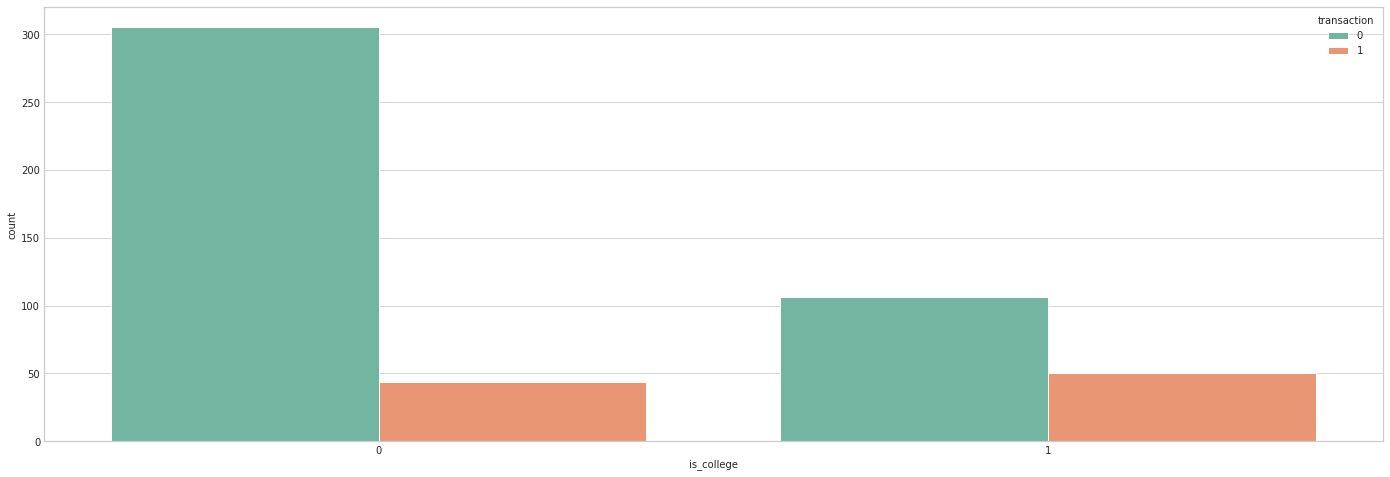

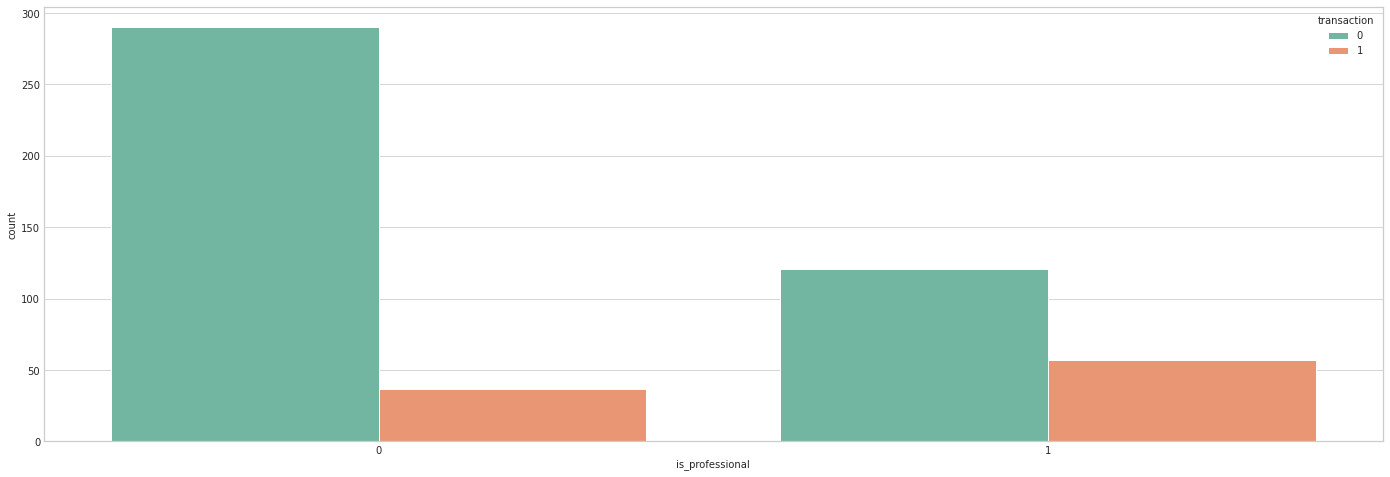

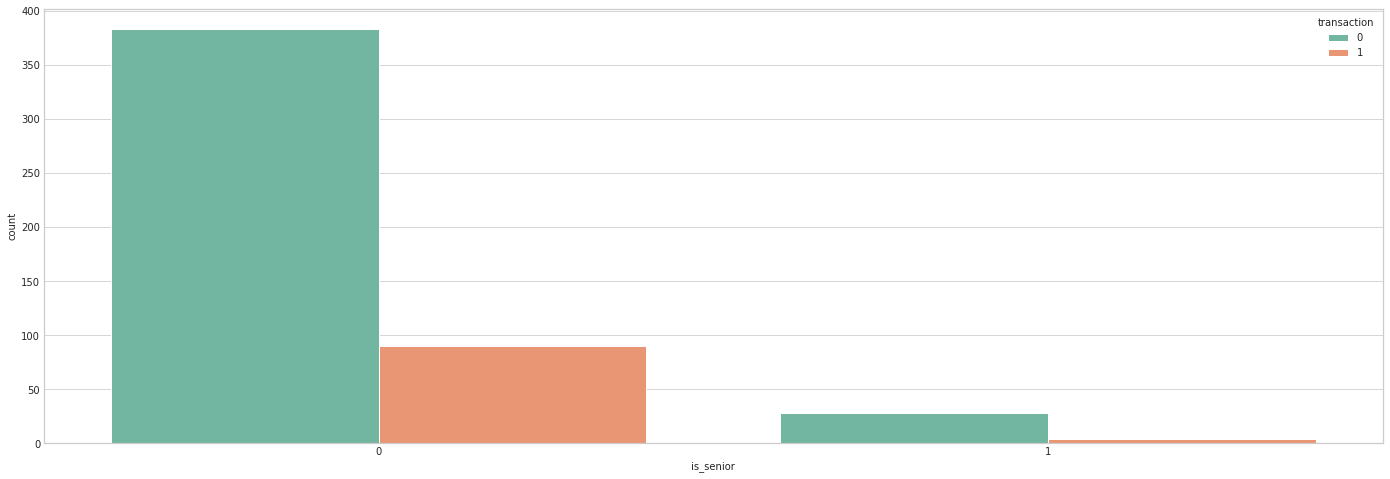

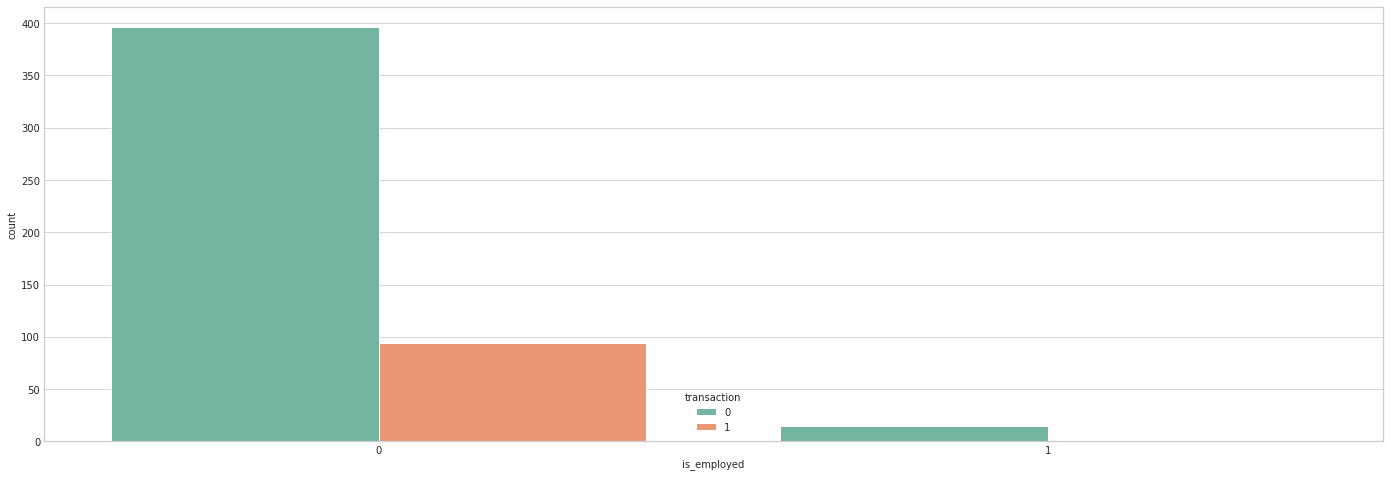

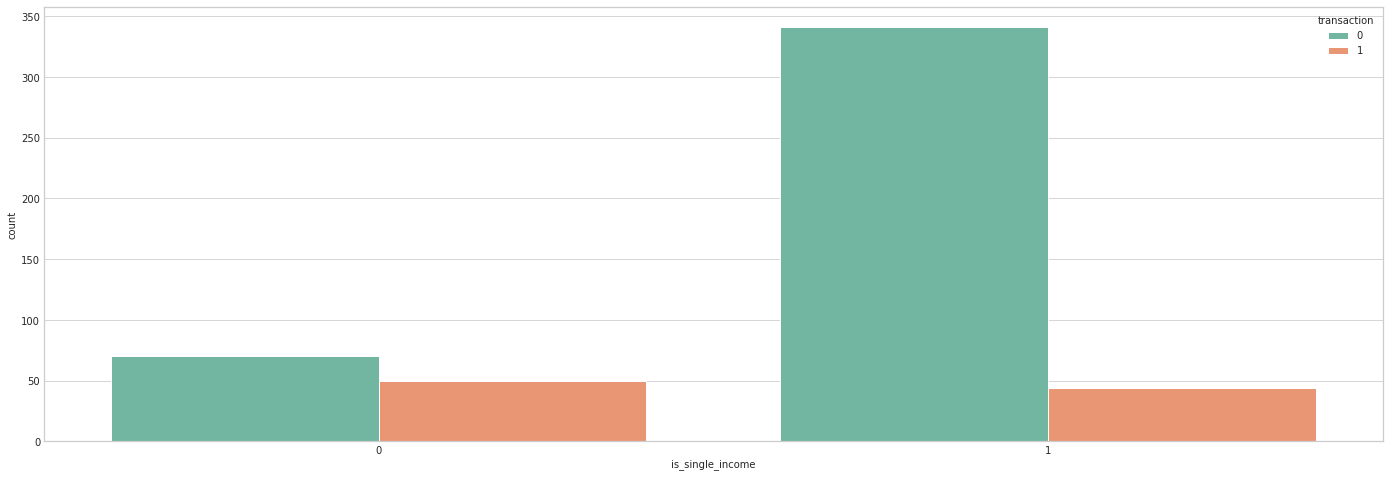

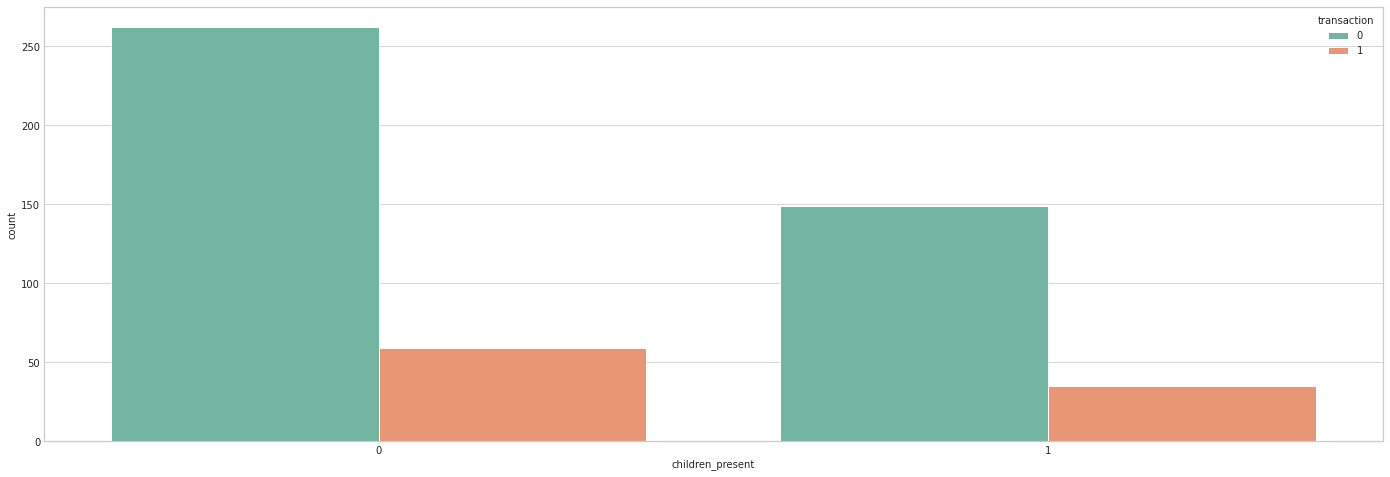

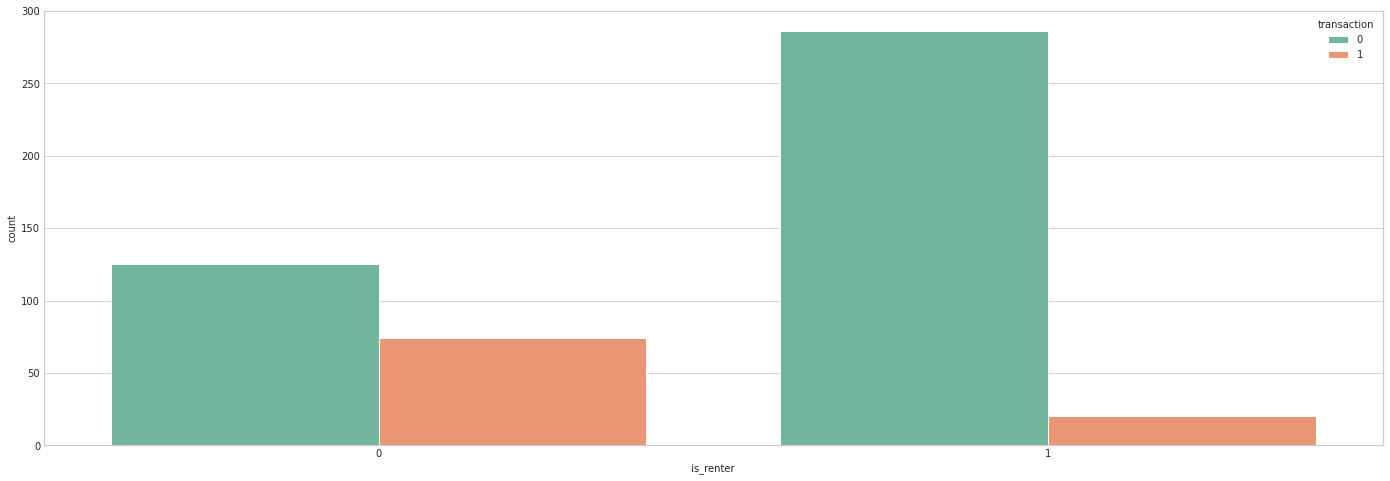

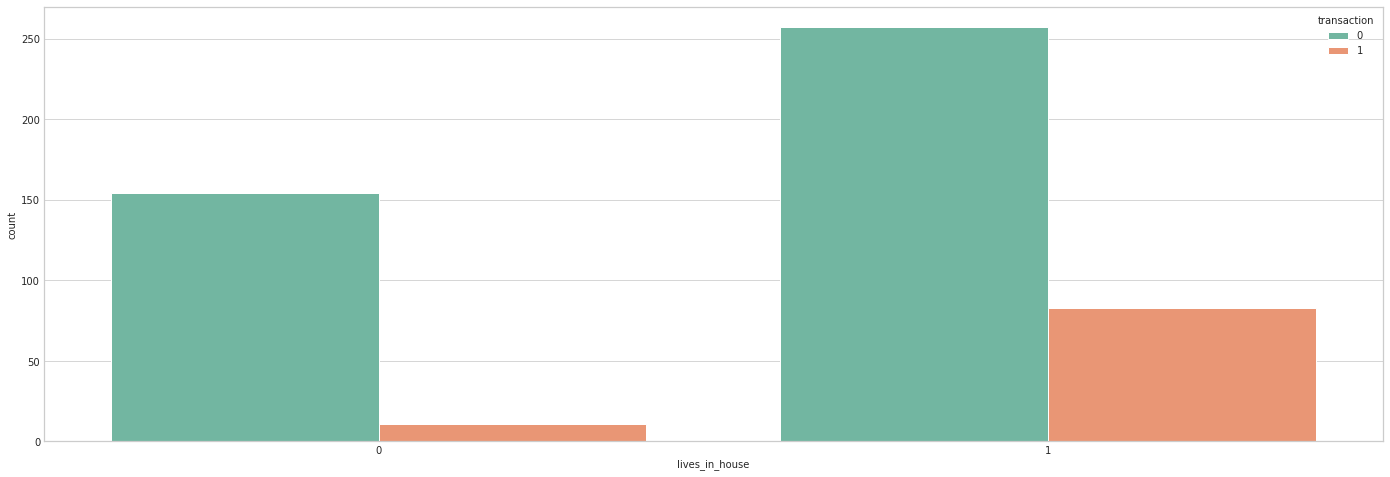

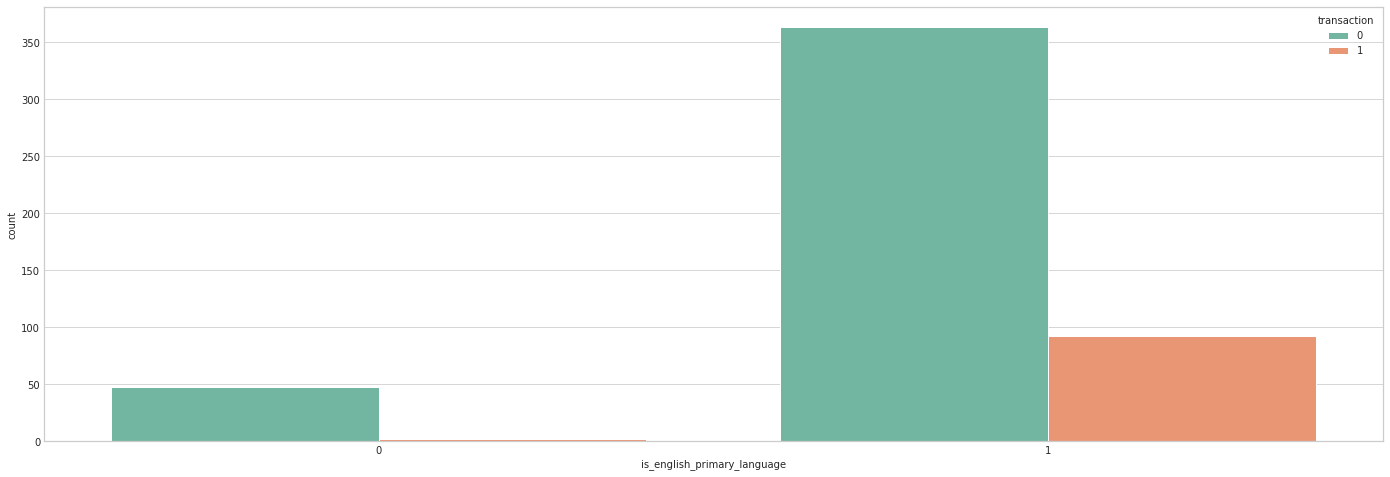

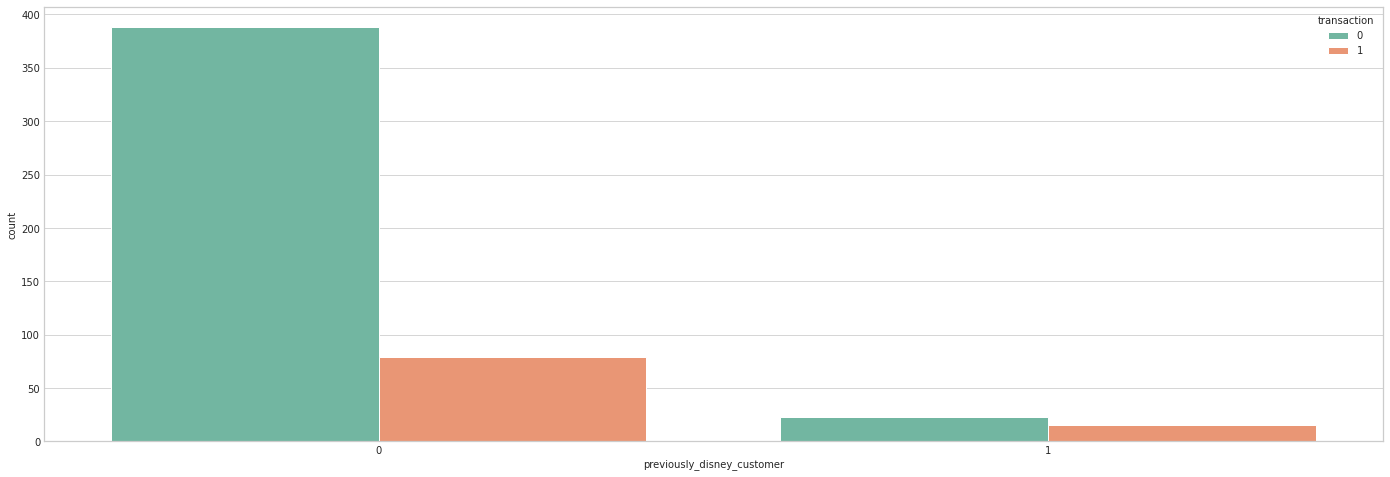

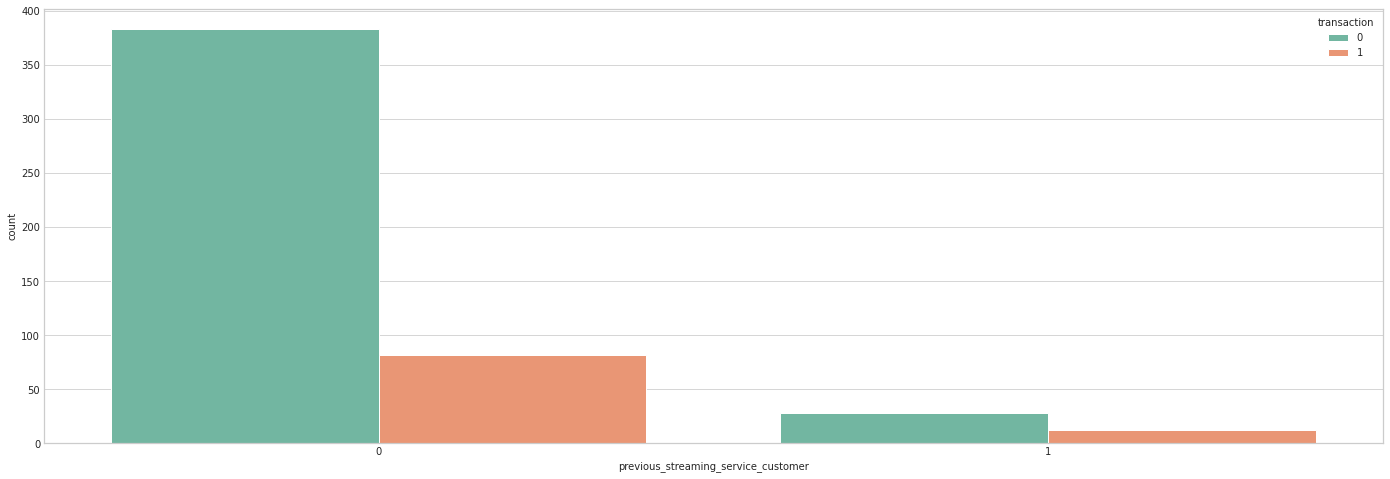

In [48]:
generate_countplot(transact_df, "transaction", color=None, palette="Set2")

In [49]:
generate_all_perc_table(transact_df, "transaction")

                         transaction
transaction transaction             
0           0                  100.0
1           1                  100.0
                        transaction
salary_usd transaction             
0          0                 100.00
2000       0                 100.00
3000       0                 100.00
5000       0                 100.00
7000       0                 100.00
...                             ...
119000     0                  50.00
           1                  50.00
121000     1                 100.00
124000     0                  13.33
           1                  86.67

[90 rows x 1 columns]
                     transaction
is_male transaction             
0       0                  78.29
        1                  21.71
1       0                  85.27
        1                  14.73
                        transaction
is_married transaction             
0          0                  93.12
           1                   6.88
1          0       

**Summary**
- People who are married have higher percetange to transact (38.92%) than those who are not married (6.88%).
- People who are college students are more likely to transact (32.05%) than those who are not college studnets (12.61%).
- People who are professionals are more likely to transact (32.02%) than those who are not professionals (11.31%).
- People who have more than one income have higher percentage to transact (41.67%) than those who have single income (11.43%).
- People who are not renters are more likely to transact (37.19%) than those who are not renters (6.54%).
- People who live in house are more likely to trnsact (24.41%) than those who do not live in house (6.67%)
- People who have English as primary language have higher percentage to transact (20.22%) than those whose primary language is not English (4%).
- People who are previous disney customer are more likely to transact (39.47%) than those who are not (16.92%).
- People who are previous streaming service customer are more likely to transact (30%) than those who are not (17.63%). 
- People who have childeren and people who do not have children have the similar percentage to transact (18~19%).

According to above summary, we could find that is_married, is_college, is_prfessionals, is_singe_income, live_in_house, is_renter, is_english_primary_language, previously_disney_customer and previous_streaming_service_customer are all possible factors that drive people to have more transact.

In [50]:
# Run the logistic regression with different attributes
run_logistic_regression_with_different_k(transact_df, "transaction")

Select 1 attributes as training data
The training attributes includes: ['is_married']
Model performance as below:
(1) Classification_report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       106
           1       0.00      0.00      0.00        21

    accuracy                           0.83       127
   macro avg       0.42      0.50      0.45       127
weighted avg       0.70      0.83      0.76       127

(2) Accuracy: 0.8346456692913385
(3) MSE: 0.16535433070866143
(4) Cross validation scores [0.82352941 0.80392157 0.80392157 0.80392157 0.80392157 0.82
 0.82       0.82       0.82       0.82      ]
(5) Cross validation mean scores 0.8139215686274509
----------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Select 2 attributes as training data
The training attributes includes: ['is_married', 'is_renter']
Model performance as below:
(1) Classification_report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       106
           1       0.00      0.00      0.00        21

    accuracy                           0.83       127
   macro avg       0.42      0.50      0.45       127
weighted avg       0.70      0.83      0.76       127

(2) Accuracy: 0.8346456692913385
(3) MSE: 0.16535433070866143
(4) Cross validation scores [0.82352941 0.80392157 0.80392157 0.80392157 0.80392157 0.82
 0.82       0.82       0.82       0.82      ]
(5) Cross validation mean scores 0.8139215686274509
----------------------------------------------------------
Select 3 attributes as training data
The training attributes includes: ['is_married', 'is_professional', 'is_renter']
Model performance as below:
(1) Classification_report:
              precision    recall  f1-

**Summary**
- From the above 14 models, we could easily see that the model using 14 training data has the overall highest performance score (accuracy, mse, cross validation mean scores).
- The most important thing is that, this model has the highest f1-score for classification = 1, which is a strong indicator for us to choose this model for predicting the transaction.

In [51]:
# Prediction model for transaction
X = transact_df[['salary_usd', 'is_male', 'is_married', 'is_college', 'is_professional', 'is_senior',\
              'is_employed', 'is_single_income', 'children_present', 'is_renter', 'lives_in_house', \
              'is_english_primary_language', 'previously_disney_customer', \
              'previous_streaming_service_customer']].values
y = transact_df["transaction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
lr_transaction_model = LogisticRegression(max_iter=1000)
lr_transaction_model.fit(X_train, y_train)
y_predict = lr_transaction_model.predict(X_test)

# Model evaluation metrics
accuracy = accuracy_score(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
cr_result = classification_report(y_test, y_predict)
cv_scores = cross_val_score(lr_transaction_model, X, y, scoring='accuracy', cv=10)

print("Model performance as below:")
print("(1) Classification_report:")
print(cr_result)
print("(2) Accuracy:", accuracy) 
print("(3) MSE:", mse)
print("(4) Cross validation scores", cv_scores)
print("(5) Cross validation mean scores", cv_scores.mean())

Model performance as below:
(1) Classification_report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       106
           1       0.67      0.86      0.75        21

    accuracy                           0.91       127
   macro avg       0.82      0.89      0.85       127
weighted avg       0.92      0.91      0.91       127

(2) Accuracy: 0.905511811023622
(3) MSE: 0.09448818897637795
(4) Cross validation scores [0.82352941 0.80392157 0.80392157 0.94117647 0.88235294 0.92
 0.82       0.82       0.82       0.82      ]
(5) Cross validation mean scores 0.8454901960784313


**Summary of transaction model using logistic regression**
- This model has overall accuracy = 0.91, MSE= 0.094, cross validation mean scores = 0.845. And we have f1-score = 0.75 for classification = 1. Overall, it would be a great model for predicting who will transact. 

## Generate some sample data for predicting using our model

In [52]:
transact_df.head(1)

,transaction,salary_usd,is_male,is_married,is_college,is_professional,is_senior,is_employed,is_single_income,children_present,is_renter,lives_in_house,is_english_primary_language,previously_disney_customer,previous_streaming_service_customer
0,0,25000,1,0,0,0,0,0,1,0,1,0,1,0,0


In [53]:
transact_df.salary_usd.describe()

count       505.000000
mean      58223.762376
std       39098.058320
min           0.000000
25%       25000.000000
50%       55000.000000
75%       86000.000000
max      124000.000000
Name: salary_usd, dtype: float64

In [54]:
# Generate random sample
random_input_2 = pd.DataFrame(columns = transact_df.columns)
random.seed(30)
for i in range(5):
  x = [0]
  x.append(random.randint(0,125000))
  x = x + [random.randint(0, 1) for i in range(13)]
  random_input_2.loc[i] = x

In [55]:
random_input_2

,transaction,salary_usd,is_male,is_married,is_college,is_professional,is_senior,is_employed,is_single_income,children_present,is_renter,lives_in_house,is_english_primary_language,previously_disney_customer,previous_streaming_service_customer
0,0,70658,1,0,0,1,0,1,1,0,0,1,0,0,0
1,0,9521,0,1,1,0,1,0,0,1,1,0,1,0,1
2,0,122387,1,0,1,1,1,0,0,0,1,0,0,1,1
3,0,23473,0,1,1,1,1,1,0,0,0,1,1,1,1
4,0,33248,1,0,0,0,1,1,0,0,1,1,1,1,1


In [56]:
# Predict our sample data
sample_X_2 = random_input_2.drop(columns=["transaction"])
sample_predict_2 = lr_transaction_model.predict(sample_X_2)

In [57]:
# Join the prediction into table
random_input_2.join(pd.DataFrame(sample_predict_2, columns= {"predict_transaction"}))

,transaction,salary_usd,is_male,is_married,is_college,is_professional,is_senior,is_employed,is_single_income,children_present,is_renter,lives_in_house,is_english_primary_language,previously_disney_customer,previous_streaming_service_customer,predict_transaction
0,0,70658,1,0,0,1,0,1,1,0,0,1,0,0,0,0
1,0,9521,0,1,1,0,1,0,0,1,1,0,1,0,1,0
2,0,122387,1,0,1,1,1,0,0,0,1,0,0,1,1,1
3,0,23473,0,1,1,1,1,1,0,0,0,1,1,1,1,0
4,0,33248,1,0,0,0,1,1,0,0,1,1,1,1,1,0


**Summary**
- According to above prediction, we could see only third record will transact based on our prediction model. This might because this record has the highest salary - even though other attributes (is_married, lives_in_house...) not align with our previous exploratory results.